In [1]:
import pandas
from pandas import DataFrame
import statsmodels
import matplotlib.pyplot as plt
import pylab as pl
import numpy
import imp

from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

import xgboost

import multiprocessing
# N_JOBS = multiprocessing.cpu_count()
N_JOBS = 7

In [23]:
train = pandas.read_csv("train.csv")
test = pandas.read_csv("test.csv")

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


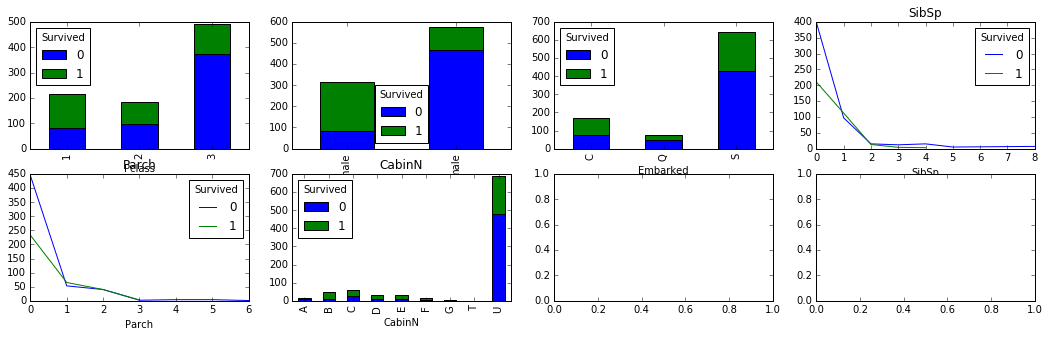

In [41]:
%matplotlib inline
train = pandas.read_csv("train.csv")
test = pandas.read_csv("test.csv")
fig, axes = plt.subplots(ncols = 4, nrows = 2)
fig.set_size_inches(18, 5)
train.loc()[train.Cabin.isnull(), "Cabin"] = "U"
train.insert(len(train.columns), "CabinN", [x[0] for x in train["Cabin"]])
train.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(ax = axes[0][0], kind='bar', stacked=True)
train.pivot_table('PassengerId', 'Sex', 'Survived', 'count').plot(ax = axes[0][1], kind='bar', stacked=True)
train.pivot_table('PassengerId', 'Embarked', 'Survived', 'count').plot(ax = axes[0][2], kind='bar', stacked=True)
train.pivot_table('PassengerId', ['SibSp'], 'Survived', 'count').plot(ax=axes[0][3], title='SibSp')
train.pivot_table('PassengerId', ['Parch'], 'Survived', 'count').plot(ax=axes[1][0], title='Parch')
train.pivot_table('PassengerId', ['CabinN'], 'Survived', 'count').plot(ax=axes[1][1], kind='bar', stacked=True, title='CabinN')

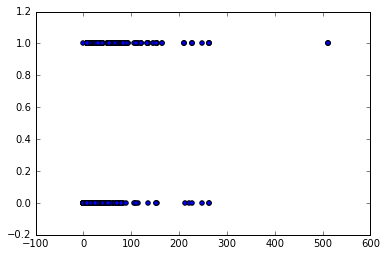

In [54]:
%matplotlib inline
plt.scatter(train['Fare'], train['Survived'])
plt.show()

In [44]:
#
# Preprocessing and scaling
#

import llama
llama = imp.reload(llama)


train = pandas.read_csv("train.csv")
test = pandas.read_csv("test.csv")
test_pid = test['PassengerId']

train.loc()[train.Cabin.isnull(), "Cabin"] = "U"
train.insert(len(train.columns), "CabinN", [x[0] for x in train["Cabin"]])
test.loc()[test.Cabin.isnull(), "Cabin"] = "U"
test.insert(len(test.columns), "CabinN", [x[0] for x in test["Cabin"]])

llama.replace_nan_fair(train)
llama.replace_nan_age(train)
llama.replace_nan_fair(test)
llama.replace_nan_age(test)

llama.set_family_size(train)
llama.set_family_size(test)

llama.set_title_column(train, test)
train = train.drop("Title", 1)
test = test.drop("Title", 1)

# columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch']
columns_to_drop2 = ['Cabin', 'CabinN_U']
dummy_columns = ['Pclass', 'Sex', 'Embarked', 'CabinN']
train = llama.make_dummies(llama.drop_columns(train, columns_to_drop), dummy_columns)
test = llama.make_dummies(llama.drop_columns(test, columns_to_drop), dummy_columns)
train = llama.drop_columns(train, columns_to_drop2)
test = llama.drop_columns(test, columns_to_drop2)
test.insert(len(test.columns), 'CabinN_T', 0)

llama.normalise(train, test, ['Fare', 'Age'])

print(train.columns)
print(len(train.columns))
print(test.columns)
print(len(test.columns))
train.describe()
train.head()

Index(['Survived', 'Age', 'Fare', 'FamilySize', 'Title_1', 'Title_2',
       'Title_3', 'Title_4', 'Title_5', 'Title_6', 'Title_7', 'Title_8',
       'Title_9', 'Title_10', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'CabinN_A',
       'CabinN_B', 'CabinN_C', 'CabinN_D', 'CabinN_E', 'CabinN_F', 'CabinN_G',
       'CabinN_T'],
      dtype='object')
30
Index(['Age', 'Fare', 'FamilySize', 'Title_1', 'Title_2', 'Title_3', 'Title_4',
       'Title_5', 'Title_6', 'Title_7', 'Title_8', 'Title_9', 'Title_10',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'CabinN_A', 'CabinN_B',
       'CabinN_C', 'CabinN_D', 'CabinN_E', 'CabinN_F', 'CabinN_G', 'CabinN_T'],
      dtype='object')
29


,Survived,Age,Fare,FamilySize,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6,...,Embarked_Q,Embarked_S,CabinN_A,CabinN_B,CabinN_C,CabinN_D,CabinN_E,CabinN_F,CabinN_G,CabinN_T
0,0,0.273456,0.014151,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0.473882,0.139136,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0.323563,0.015469,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,0.436302,0.103644,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,0,0.436302,0.015713,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


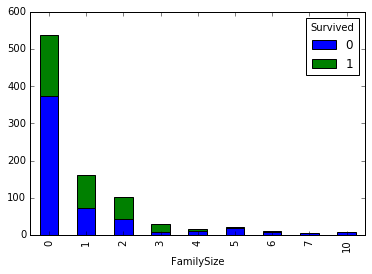

In [56]:
%matplotlib inline
train.insert(0, 'PassengerId', [x for x in range(len(train))])
train.pivot_table('PassengerId', 'FamilySize', 'Survived', 'count').plot(kind='bar', stacked=True)

In [46]:
#
# Shuffling for Cross Validation
#


if "PassengerId" in train.columns:
    train = train.drop("PassengerId", 1)
train_y = train['Survived']
train_X = train.drop('Survived', 1)

train_shuf = StratifiedShuffleSplit(train_y, n_iter = 5, test_size = .2, random_state = 123)

In [47]:
#
# Classifiers
#


def run_grid_search(train_X, train_y, clf, params, cv, n_jobs = N_JOBS):
    gs = GridSearchCV(clf, params, n_jobs = n_jobs, cv = cv, verbose=1)
    gs = gs.fit(train_X, train_y)
    print("Best estimator:\n", gs.best_estimator_)
    print("Grid search score:\t", gs.best_score_)
    clf = gs.best_estimator_
    cv_new = StratifiedShuffleSplit(train_y, n_iter = 10, test_size = .2, random_state = 345)
    score = cross_val_score(clf, train_X, train_y, cv=cv_new)
    print("CV score:\t", score, '\n=> ', score.mean(), ' (+-', score.std(),')\n', sep = '')
    return clf


# clfs = [ensemble.RandomForestClassifier(), 
#         linear_model.LogisticRegression(C = 1),
#         svm.SVC(C = 10000)]

# for clf in clfs:
#     print(clf)
#     score = cross_val_score(clf, train_X, train_y, cv=train_shuf)
#     print(score, '\n=> ', score.mean(), ' (+-', score.std(),')\n', sep = '')


# GRADIENT BOOSTING
# parameters = {'loss': ['ls', 'lad', 'huber', 'quantile'], 
#               'n_estimators': [30, 100, 300, 600, 1000]}
#               'max_depth': [1, 2, 3, 5, 7],
#               'subsample': [1], 
#               'max_features': ['auto']}
# parameters = {'loss': ['deviance', 'exponential'], 
#               'n_estimators': [15, 30, 50, 75],
#               'max_depth': [1, 2, 3],
#               'subsample': [1, .7, .3],
#               'max_features': [4, 5, 6]}
# clf = GradientBoostingClassifier()
# gs = GridSearchCV(clf, parameters, n_jobs = N_JOBS, cv = train_shuf)
# gs = gs.fit(train_X, train_y)
# best_logreg = gs.best_estimator_


# LOGISTIC REGRESSION
# parameters = {'C': 10.**numpy.arange(-1, 0, .05), 'penalty': ['l2']}
# clf = linear_model.LogisticRegression()
# gs = GridSearchCV(clf, parameters, n_jobs = N_JOBS, cv = train_shuf)
# gs = gs.fit(train_X, train_y)
# best_logreg = gs.best_estimator_


# SVM
# parameters = {'kernel': ['linear'], 
#               'C': 10. ** numpy.arange(-1.8, -1.7, .001)
#              }
# clf = svm.SVC()
# gs = GridSearchCV(clf, parameters, n_jobs = N_JOBS, cv = train_shuf)
# gs = gs.fit(train_X, train_y)
# print("LINEAR")
# print(gs.best_score_)
# print(gs.best_estimator_)

# parameters = {'kernel': ['rbf'], 
#               'C': 10. ** numpy.arange(3, 3.4, .02),
#               'degree': [2],
#               'gamma': numpy.arange(.2, .3, .005)
#              }
# clf = svm.SVC()
# gs = GridSearchCV(clf, parameters, n_jobs = N_JOBS, cv = train_shuf)
# gs = gs.fit(train_X, train_y)
# print("RBF")
# print(gs.best_score_)
# print(gs.best_estimator_)

# parameters = {'kernel': ['poly'], 
#               'C': 10. ** numpy.arange(5, 6, .01),
#               'gamma': ['auto'],
#               'coef0': 10. ** numpy.arange(-5, 5, 1)
#              }
# gs = GridSearchCV(clf, parameters, n_jobs = N_JOBS, cv = train_shuf)
# gs = gs.fit(train_X, train_y)
# print("POLY")
# print(gs.best_score_)
# print(gs.best_estimator_)

# clf = svm.SVC()
# parameters = {'kernel': ['sigmoid'], 
#               'C': 10. ** numpy.arange(1.8, 2.5, .1),
#               'gamma': ['auto'],
#               'coef0': 10. ** numpy.arange(-5, 5, 1)
#              }
# gs = GridSearchCV(clf, parameters, n_jobs = N_JOBS,cv = train_shuf)
# gs = gs.fit(train_X, train_y)
# print("SIGMOID")
# print(gs.best_score_)
# print(gs.best_estimator_)

# clf_list.append(RandomForestClassifier())
# temp_par = {'n_estimators': [15, 30, 50, 75, 130, 200, 300, 400, 500, 600, 700], 
#             'max_features': numpy.arange(2, len(train_X.columns), 2),
#             'bootstrap': [True, False],
#             'criterion': ['gini', 'entropy']
#             }
# par_list.append(temp_par)

# clf_list.append(ExtraTreesClassifier())
# temp_par = {'n_estimators': [15, 30, 50, 75, 130, 200, 300, 400, 500, 600, 700], 
#             'max_features': numpy.arange(2, len(train_X.columns), 2),
#             'bootstrap': [True, False],
#             'criterion': ['gini', 'entropy']
#             }
# par_list.append(temp_par)


# ENSEMBLES
clf_list = []
par_list = []

clf_list.append(GradientBoostingClassifier())
temp_par = {'loss': ['deviance', 'exponential'],
            'n_estimators': [15, 30, 40, 50, 65, 75, 85, 100], 
            'max_features': [11, 12, 13, 14],
            'max_depth': [6, 7, 8, 9],
            'min_samples_leaf': [2, 3, 4, 5],
            'min_samples_split': [3, 4, 5, 6],
            'learning_rate': [.007]
            }
par_list.append(temp_par)

for i in range(len(clf_list)):
    run_grid_search(train_X, train_y, clf_list[i], par_list[i], train_shuf)

Fitting 5 folds for each of 4096 candidates, totalling 20480 fits


[Parallel(n_jobs=7)]: Done 190 tasks      | elapsed:    4.4s
[Parallel(n_jobs=7)]: Done 810 tasks      | elapsed:   16.5s
[Parallel(n_jobs=7)]: Done 1810 tasks      | elapsed:   37.1s
[Parallel(n_jobs=7)]: Done 3210 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 5010 tasks      | elapsed:  1.9min
[Parallel(n_jobs=7)]: Done 7194 tasks      | elapsed:  3.0min
[Parallel(n_jobs=7)]: Done 8494 tasks      | elapsed:  3.6min
[Parallel(n_jobs=7)]: Done 9994 tasks      | elapsed:  4.5min
[Parallel(n_jobs=7)]: Done 11694 tasks      | elapsed:  5.1min
[Parallel(n_jobs=7)]: Done 13594 tasks      | elapsed:  5.9min
[Parallel(n_jobs=7)]: Done 15694 tasks      | elapsed:  6.9min
[Parallel(n_jobs=7)]: Done 17994 tasks      | elapsed:  8.2min


KeyboardInterrupt: 

In [ ]:
#
# Writing the output
#

clf = GradientBoostingClassifier(init=None, learning_rate=0.007, loss='deviance',
              max_depth=7, max_features=13, max_leaf_nodes=None,
              min_samples_leaf=2, min_samples_split=6,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
postfix = ".gb"
print(clf)
clf.fit(train_X, train_y)

result = DataFrame()
clf.predict(test)
result.insert(0, 'PassengerId', test_pid)
result.insert(1, "Survived", clf.predict(test))

result.to_csv("out" + postfix + ".csv", index = False)

In [60]:
#
# Stacking
#

import llama
llama = imp.reload(llama)


# Best SVM
'''
SVC(C=1737.8008287493763, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=0.21000000000000002,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

'''
model_svm = SVC(C=1737.8008287493763, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=0.21000000000000002,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


# Best LogReg
'''
LogisticRegression(C=0.22387211385683412, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
'''
model_logreg = LogisticRegression(C=0.22387211385683412, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=N_JOBS, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# Best RF
'''
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
'''
model_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=N_JOBS,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Best GB
model_gb = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance', 
                                      max_depth=2, max_features=5, max_leaf_nodes=None, 
                                      min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, 
                                      n_estimators=50, presort='auto', random_state=None, subsample=1, 
                                      verbose=0, warm_start=False)


df = DataFrame()
llama.insert_predictions(df, llama.stacking_model_predict(model_svm, train_X, train_y, train_X), 'SVM')
llama.insert_predictions(df, llama.stacking_model_predict(model_logreg, train_X, train_y, train_X), 'LogReg')
llama.insert_predictions(df, llama.stacking_model_predict(model_rf, train_X, train_y, train_X), 'RF')
df.head()

,SVM0,SVM1,LogReg0,LogReg1,RF0,RF1
0,0.811582,0.188418,0.916692,0.083308,0.911538,0.088462
1,0.100934,0.899066,0.080698,0.919302,0.000000,1.000000
2,0.287347,0.712653,0.339785,0.660215,0.130769,0.869231
3,0.135303,0.864697,0.079704,0.920296,0.000000,1.000000
4,0.803446,0.196554,0.902994,0.097006,0.992308,0.007692


In [61]:
# parameters = {'C': 10.**numpy.arange(-1.4, -.9, .0001), 'penalty': ['l1']}
# stack_model = linear_model.LogisticRegression()
stack_model = VotingClassifier(estimators = [#("svm", model_svm), 
                                             ("logreg", model_logreg), 
                                             ("rf", model_rf),
                                             ("gb", model_gb)], 
                               voting = 'soft')
# gs = GridSearchCV(stack_model, parameters, n_jobs = N_JOBS, cv = train_shuf)
# gs = gs.fit(df, train_y)
# print(gs.best_estimator_)
# print(gs.best_score_)


print(stack_model)
score = cross_val_score(stack_model, train_X, train_y, cv=train_shuf)
print(score, '\n=> ', score.mean(), ' (+-', score.std(),')\n', sep = '')

VotingClassifier(estimators=[('logreg', LogisticRegression(C=0.22387211385683412, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=Fal...        presort='auto', random_state=None, subsample=1, verbose=0,
              warm_start=False))],
         voting='soft', weights=None)
[ 0.83240223  0.82681564  0.82122905  0.81564246  0.87150838  0.84916201
  0.8547486   0.82681564  0.7877095   0.84916201]
=> 0.833519553073 (+-0.022457822617)



In [62]:
#
# Writing the stacking output
#


# df = DataFrame()
# insert_predictions(df, stacking_model_predict(model_svm, train_X, train_y, test), 'SVM')
# insert_predictions(df, stacking_model_predict(model_logreg, train_X, train_y, test), 'LogReg')
# insert_predictions(df, stacking_model_predict(model_rf, train_X, train_y, test), 'RF')

# clf = gs.best_estimator_
# print(clf)

stack_model.fit(train_X, train_y)

result = DataFrame()
result.insert(0, 'PassengerId', test_pid)
result.insert(1, "Survived", stack_model.predict(test))

result.to_csv("out_stacking.csv", index = False)

In [63]:
new_train_X = train_X.append(test)
new_train_y = numpy.concatenate([train_y, stack_model.predict(test)], 0)

new_train_shuf = StratifiedShuffleSplit(new_train_y, n_iter = 10, test_size = .2, random_state = 123)

parameters = {'loss': ['deviance', 'exponential'], 
              'n_estimators': [15, 30, 50, 75],
              'max_depth': [1, 2, 3],
              'subsample': [1, .7, .3],
              'max_features': [4, 5, 6]}
clf = GradientBoostingClassifier()
gs = GridSearchCV(clf, parameters, n_jobs = N_JOBS, cv = new_train_shuf)
gs = gs.fit(new_train_X, new_train_y)
print(gs.best_estimator_)
print(gs.best_score_)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=6, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=75,
              presort='auto', random_state=None, subsample=0.3, verbose=0,
              warm_start=False)
0.884732824427


In [64]:
clf = gs.best_estimator_
print(clf)
clf.fit(new_train_X, new_train_y)

result = DataFrame()
result.insert(0, 'PassengerId', test_pid)
result.insert(1, "Survived", clf.predict(test))

result.to_csv("out_usetest.csv", index = False)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=6, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=75,
              presort='auto', random_state=None, subsample=0.3, verbose=0,
              warm_start=False)
